# Correct for the technical variation added

The goal of this notebook is to try to correct for the technical variation that was added by each experiment

The approach is to,
1. Import the simulated data representing varying experiments
2. Use [removeBatchEffect](https://rdrr.io/bioc/limma/man/removeBatchEffect.html) package from the limma library in R.
3. Calculate the similarity between the dataset with a single experiment and the dataset corrected for the variation introduced by having some number of experiments added.

In [21]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
limma = importr('limma')

import os
import sys
import glob
import pandas as pd
import numpy as np
from plotnine import (ggplot, 
                      labs,  
                      geom_line, 
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      element_text,
                      element_rect,
                      element_line)
import warnings
warnings.filterwarnings(action='ignore')

sys.path.append("../")
from functions import generate_data
from functions import similarity_metric

from numpy.random import seed
randomState = 123
seed(randomState)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
# Run once to install needed R packages
#install.packages(c("devtools"))
#source("http://www.bioconductor.org/biocLite.R")
#biocLite(c("limma"))
library(limma)

In [3]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'
lst_num_partitions =[1,2,3,5,10,20,30,50,70,100,200,300,400,500,600]
use_pca = True
num_PCs = 10

In [4]:
# Input files
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))    # base dir on repo
local_dir = "/home/alexandra/Documents/"                         # base dir on local machine for data storage

# Simulated data file 
simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

In [25]:
# Output file
svcca_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_svcca_correction.png")

svcca_blk_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_svcca_correction_blk.png")

similarity_corrected_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_1_similarity_corrected.pickle")

### Correct for added variation

In [6]:
for i in lst_num_partitions:
    print('Correcting for {} partitions..'.format(i))

    # Simulated data with technical variation from partitions added
    partition_file = os.path.join(
        local_dir,
        "Data",
        "Batch_effects",
        "partition_simulated",
        analysis_name,
        "Partition_" + str(i) + ".txt.xz")
    
    # Read in data
    # data transposed to form gene x sample for R package
    partition_data = pd.read_table(
        partition_file,
        header=0,
        index_col=0,
        sep='\t').T
    
    # Read in partition id mapping
    partition_map_file = os.path.join(
        local_dir,
        "Data",
        "Batch_effects",
        "partition_simulated",
        analysis_name,
        "Partition_map_" + str(i) + ".txt.xz")
    
    # Read in map
    partition_map = pd.read_table(
        partition_map_file,
        header=0,
        index_col=0,
        sep='\t')['partition']
    
    if i == 1:
        corrected_partition_data_df = partition_data.copy()
    
    else:    
        # Correct for technical variation
        corrected_partition_data = limma.removeBatchEffect(partition_data, batch=partition_map)

        # Convert R object to pandas df
        corrected_partition_data_df = pandas2ri.ri2py_dataframe(corrected_partition_data)
        
        # Rename columns to be consistent with dataframe before correction
        corrected_partition_data_df.index = partition_data.index
    
    # Write out corrected files
    partition_corrected_file = os.path.join(
        local_dir,
        "Data",
        "Batch_effects",
        "partition_simulated",
        analysis_name,
        "Partition_corrected_" + str(i) + ".txt.xz")
    
    corrected_partition_data_df.to_csv(
        partition_corrected_file, float_format='%.3f', sep='\t', compression='xz')

Correcting for 1 partitions..
Correcting for 2 partitions..
Correcting for 3 partitions..
Correcting for 5 partitions..
Correcting for 10 partitions..
Correcting for 20 partitions..
Correcting for 30 partitions..
Correcting for 50 partitions..
Correcting for 70 partitions..
Correcting for 100 partitions..
Correcting for 200 partitions..
Correcting for 300 partitions..
Correcting for 400 partitions..
Correcting for 500 partitions..
Correcting for 600 partitions..


### Calculate similarity

In [7]:
# Permuted simulated data file 
permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

In [8]:
# Calculate similarity
similarity_scores, permuted_score = similarity_metric.sim_svcca(simulated_data_file,
                                                           permuted_simulated_data_file,
                                                           "Partition_corrected",
                                                           lst_num_partitions,
                                                           use_pca,
                                                           num_PCs,
                                                           local_dir,
                                                           analysis_name)

Calculating SVCCA score for 1 partition vs 1 partitions..
Calculating SVCCA score for 1 partition vs 2 partitions..
Calculating SVCCA score for 1 partition vs 3 partitions..
Calculating SVCCA score for 1 partition vs 5 partitions..
Calculating SVCCA score for 1 partition vs 10 partitions..
Calculating SVCCA score for 1 partition vs 20 partitions..
Calculating SVCCA score for 1 partition vs 30 partitions..
Calculating SVCCA score for 1 partition vs 50 partitions..
Calculating SVCCA score for 1 partition vs 70 partitions..
Calculating SVCCA score for 1 partition vs 100 partitions..
Calculating SVCCA score for 1 partition vs 200 partitions..
Calculating SVCCA score for 1 partition vs 300 partitions..
Calculating SVCCA score for 1 partition vs 400 partitions..
Calculating SVCCA score for 1 partition vs 500 partitions..
Calculating SVCCA score for 1 partition vs 600 partitions..


In [9]:
# Convert similarity scores to pandas dataframe
similarity_score_df = pd.DataFrame(data={'score': similarity_scores},
                                     index=lst_num_partitions,
                                    columns=['score'])
similarity_score_df.index.name = 'number of partitions'
similarity_score_df

,score
number of partitions,
1,0.999994
2,0.998682
3,0.996184
5,0.995955
10,0.985756
20,0.975576
30,0.951873
50,0.942219
70,0.906548


In [10]:
print("Similarity between input vs permuted data is {}".format(permuted_score))

Similarity between input vs permuted data is 0.12339763210579076


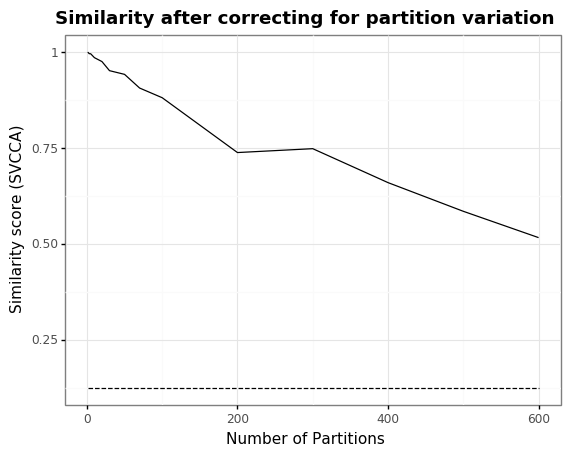

<ggplot: (-9223363276562037216)>


In [17]:
# Plot
threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_partitions), 1)),
    index=lst_num_partitions,
    columns=['score'])

g = ggplot(similarity_score_df, aes(x=lst_num_partitions, y='score')) \
    + geom_line() \
    + geom_line(aes(x=lst_num_partitions, y='score'), threshold, linetype='dashed') \
    + labs(x = "Number of Partitions", 
           y = "Similarity score (SVCCA)", 
           title = "Similarity after correcting for partition variation") \
    + theme_bw() \
    + theme(plot_title=element_text(weight='bold'))

print(g)
ggsave(plot=g, filename=svcca_file, dpi=300)

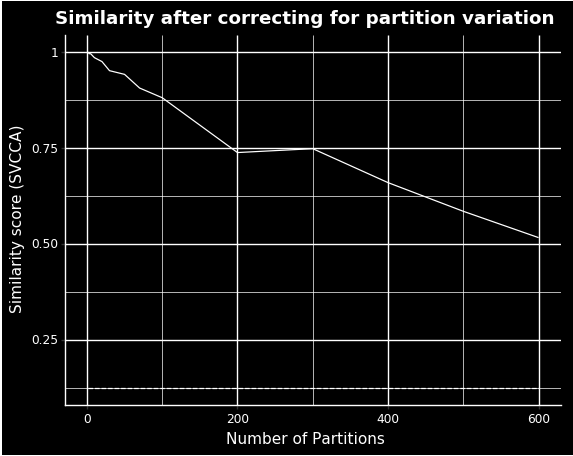

<ggplot: (-9223363276562956628)>


In [24]:
# Plot - black
threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_partitions), 1)),
    index=lst_num_partitions,
    columns=['score'])

g = ggplot(similarity_score_df, aes(x=lst_num_partitions, y='score')) \
    + geom_line(colour="white") \
    + geom_line(aes(x=lst_num_partitions, y='score'), threshold, colour="white", linetype='dashed') \
    + labs(x = "Number of Partitions", 
           y = "Similarity score (SVCCA)", 
           title = "Similarity after correcting for partition variation") \
    + theme(plot_title=element_text(weight='bold', colour="white"),
            plot_background=element_rect(fill="black"),
            panel_background=element_rect(fill="black"),
            axis_title_x=element_text(colour="white"),
            axis_title_y=element_text(colour="white"),
            axis_line=element_line(color="white"),
            axis_text=element_text(color="white")
           )

print(g)
ggsave(plot=g, filename=svcca_blk_file, dpi=300)

In [26]:
# Pickle similarity scores to overlay uncorrected and corrected svcca curves
similarity_score_df.to_pickle(similarity_corrected_file)